In [1]:
import pandas as pd
import os

# Display all rows
pd.set_option('display.max_rows', None)

# Display all columns
pd.set_option('display.max_columns', None)

# # Display full column width
# pd.set_option('display.max_colwidth', -1)

# display(df)

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


cmap = cm.get_cmap("Greys")  # or "viridis", "plasma", etc.

def my_compression_plotter(subset, group_col, metric, base_line, title:str = None):
    plt.figure(figsize=(10, 6))

    # Normalize compression values for colormap
    compression_values = subset["compression_ratio"].astype(float)
    norm = mcolors.Normalize(vmin=compression_values.min(), vmax=compression_values.max())

    for i, (name, group) in enumerate(subset.groupby(group_col)):
        x = group["num_new_tokens"]
        y = group[metric]
        compression = group["compression_ratio"].astype(float)
        compression_str = (compression * 100).round(1).astype(str) + "%"

        label = " | ".join(name)
        plt.plot(x, y, color=f"C{i}", label=label)

        colors = cmap(norm(compression))
        plt.scatter(x, y, c=colors, edgecolor='k', s=60)
        # Add annotations
        for xi, yi, text in zip(x, y, compression_str):
            plt.annotate(text, (xi, yi), textcoords="offset points", xytext=(5, 5), ha='left', fontsize=9)

    plt.axhline(y=base_line[metric].values[0], color='gray', linestyle='--', linewidth=1.5, label='Baseline')

    plt.xlabel("Number of New Tokens")
    plt.ylabel("Accuracy")
    if title:
        plt.title(title)
    else:
        plt.title("Accuracy vs Number of New Tokens by Finetuning")
    plt.legend(title='|'.join(group_col))
    plt.grid(True)
    plt.tight_layout()
    plt.show()



/cmlscratch/astein0/tmp/ipykernel_3167261/50461555.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Greys")  # or "viridis", "plasma", etc.


In [3]:
results_dir = "eval_results"

def get_results(results_file_name: str, experiment: str):
    results_file = os.path.join(results_dir, experiment, results_file_name)

    df = pd.read_csv(results_file)

    main_results = df[df["alias"] == "ifeval"]
    main_results.fillna("NAN", inplace=True)
    # main_results = main_results[main_results["limit"] == "NAN"]
    main_results["task_name"].replace("ifeval", "baseline", inplace=True)
    for _, row in main_results.iterrows():
        if not "num_new_tokens" in row.keys() or row["num_new_tokens"] == "NAN":
            model_name = row["model_name_sanitized"]
            model_name_split = model_name.split("-")
            try:
                num_toks = int(model_name_split[-1])
                main_results.loc[row.name, "num_new_tokens"] = num_toks
            except:
                print(f"Error: {row}")
    return main_results
                

def get_aggregated_results(result_df: pd.DataFrame, column: list[str]) -> pd.DataFrame:
    aggregated_results = result_df.groupby(column).agg({
        "prompt_level_strict_acc": ["mean", "std", "count", "max"],
        "inst_level_strict_acc": ["mean", "std", "count", "max"],
        "prompt_level_loose_acc": ["mean", "std", "count", "max"],
        "inst_level_loose_acc": ["mean", "std", "count", "max"],
        "compression_ratio": ["mean"],
        "learning_ratio": ["mean"],
        "theoretical_compression_ratio": ["mean"],
    })
    return aggregated_results

# FOR IF EVAL
# experiment = "templating" # instruct with no embeddings trained
# experiment = "baseline_embeddings"
# experiment = "patching"
# experiment = "longer_embeddings" # instruct with embeddings trained
experiment = "full_patching"
results_file_name = "eval_results.csv"
main_results = get_results(results_file_name, experiment)
# main_results.sort_values(by="exact_match", ascending=True)
print(main_results.sort_values(by="prompt_level_strict_acc", ascending=True))

if experiment == "longer_embeddings":
    main_results.loc[main_results["finetuning_params"] == "embeddings", "finetuning_params"] = "lora"

# templating_results = get_results(results_file_name, "templating")
# patching_results = get_results(results_file_name, "patching")
# main_results = pd.concat([templating_results, patching_results])
main_results.sort_values(by="prompt_level_strict_acc", ascending=True)
main_results.fillna("NAN", inplace=True)
display(main_results)


/cmlscratch/astein0/tmp/ipykernel_3167261/405337152.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NAN' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  main_results.fillna("NAN", inplace=True)
/cmlscratch/astein0/tmp/ipykernel_3167261/405337152.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  main_results["task_name"].replace("ifeval", "baseline", inplace=True)


Error: model_name_sanitized                                       meta-llama__Llama-3.2-3B
trained_model_name                                         meta-llama__Llama-3.2-3B
model_name                                                             Llama-3.2-3B
embeddings_init                                                                 NAN
task_name                                                                  baseline
exact_match                                                                     NAN
exact_match_stderr                                                              NAN
prompt_level_strict_acc                                                    0.195933
prompt_level_strict_acc_stderr                                             0.017081
inst_level_strict_acc                                                       0.32494
inst_level_strict_acc_stderr                                                    NAN
prompt_level_loose_acc                                               

,model_name_sanitized,trained_model_name,model_name,embeddings_init,task_name,exact_match,exact_match_stderr,prompt_level_strict_acc,prompt_level_strict_acc_stderr,inst_level_strict_acc,inst_level_strict_acc_stderr,prompt_level_loose_acc,prompt_level_loose_acc_stderr,inst_level_loose_acc,inst_level_loose_acc_stderr,compression_ratio,learning_ratio,theoretical_compression_ratio,alias,limit,json_path,dataset_str,finetuning_params,total_batch_size,learning_rate,main_loss_type,embedding_init_strategy,num_new_tokens,unfreeze_params_steps,finetune_params_prefreeze,dataset,tokenizer_path,seed,reset_optimizer,warmup_steps,lr_schedule,warmup_steps_prefreeze,lr_schedule_prefreeze
0,output__full_patching__ba7c8b60-Llama-3.2-3B-m...,output__full_patching__ba7c8b60-Llama-3.2-3B-m...,Llama-3.2-3B,NAN,mixed,NAN,NAN,0.192237,0.016958,0.305755,NAN,0.207024,0.017436,0.329736,NAN,0.133380,0.034137,0.170377,ifeval,NAN,eval_results/full_patching/output__full_patchi...,"translation, default",new_tokens_only,32.0,0.0005,mixed,merge,1000.0,-1.0,NAN,"magpie-default-tokenized_1000,magpie-translati...",/cmlscratch/astein0/efficient_tokenization_for...,1234.0,False,100.0,cosine,-1.0,NAN
1,meta-llama__Llama-3.2-3B,4eb8fba9-Llama-3.2-3B-mixed-1000,Llama-3.2-3B,NAN,mixed,NAN,NAN,0.134935,0.014702,0.262590,NAN,0.146026,0.015196,0.273381,NAN,0.101597,0.022770,0.122494,ifeval,NAN,eval_results/full_patching/4eb8fba9-Llama-3.2-...,default,embeddings,32.0,0.0005,mixed,merge,1000.0,-1.0,NAN,magpie-default-tokenized_1000,/cmlscratch/astein0/efficient_tokenization_for...,1234.0,False,100.0,cosine,-1.0,NAN
2,meta-llama__Llama-3.2-3B-Instruct,4eb8fba9-Llama-3.2-3B-mixed-1000,Llama-3.2-3B,NAN,mixed,NAN,NAN,0.327172,0.020190,0.468825,NAN,0.414048,0.021196,0.552758,NAN,0.016155,-0.000890,0.014179,ifeval,NAN,eval_results/full_patching/4eb8fba9-Llama-3.2-...,default,embeddings,32.0,0.0005,mixed,merge,1000.0,-1.0,NAN,magpie-default-tokenized_1000,/cmlscratch/astein0/efficient_tokenization_for...,1234.0,False,100.0,cosine,-1.0,NAN
3,meta-llama__Llama-3.2-3B-Instruct,508aaf68-Llama-3.2-3B-mixed-100,Llama-3.2-3B,new_only,mixed,NAN,NAN,0.663586,0.020332,0.757794,NAN,0.719039,0.019342,0.799760,NAN,-0.004844,0.065750,0.059344,ifeval,NAN,eval_results/full_patching/508aaf68-Llama-3.2-...,default,new_tokens_only,32.0,0.0005,mixed,merge,100.0,-1.0,NAN,magpie-default-tokenized_100,/cmlscratch/astein0/efficient_tokenization_for...,1234.0,False,100.0,cosine,-1.0,NAN
4,meta-llama__Llama-3.2-3B-Instruct,508aaf68-Llama-3.2-3B-mixed-100,Llama-3.2-3B,new_only,mixed,NAN,NAN,0.658041,0.020413,0.752998,NAN,0.707948,0.019567,0.793765,NAN,-0.005003,0.066387,0.059817,ifeval,NAN,eval_results/full_patching/508aaf68-Llama-3.2-...,default,new_tokens_only,32.0,0.0005,mixed,merge,100.0,-1.0,NAN,magpie-default-tokenized_100,/cmlscratch/astein0/efficient_tokenization_for...,1234.0,False,100.0,cosine,-1.0,NAN
5,meta-llama__Llama-3.2-3B-Instruct,d2d49ae1-Llama-3.2-3B-mixed-10,Llama-3.2-3B,new_only,mixed,NAN,NAN,0.693161,0.019846,0.778177,NAN,0.737523,0.018934,0.814149,NAN,-0.008155,0.025803,0.015955,ifeval,NAN,eval_results/full_patching/d2d49ae1-Llama-3.2-...,"translation, default",new_tokens_only,32.0,0.0005,mixed,merge,10.0,-1.0,NAN,"magpie-default-tokenized_10,magpie-translation...",/cmlscratch/astein0/efficient_tokenization_for...,1234.0,False,100.0,cosine,-1.0,NAN
6,meta-llama__Llama-3.2-3B-Instruct,d2d49ae1-Llama-3.2-3B-mixed-10,Llama-3.2-3B,new_only,mixed,NAN,NAN,0.698706,0.019744,0.779376,NAN,0.741220,0.018847,0.816547,NAN,-0.008277,0.025612,0.015627,ifeval,NAN,eval_results/full_patching/d2d49ae1-Llama-3.2-...,"translation, default",new_tokens_only,32.0,0.0005,mixed,merge,10.0,-1.0,NAN,"magpie-default-tokenized_10,magpie-translation...",/cmlscratch/astein0/efficient_tokenization_for...,1234.0,False,100.0,cosine,-1.0,NAN
7,meta-llama__Llama-3.2-3B-Instruct,2916d55c-Llama-3.2-3B-Instruct-mixed-100,Llama-3.2-3B-Instruct,NAN,mixed,NAN,NAN,0.685767,0.019976,0.767386,NAN,0.739372,0.018891,0.810552,NAN,0.0

In [31]:
agg_col = ["num_new_tokens", "finetuning_params", "model_name", "trained_model_name", "model_name_sanitized", "dataset"]
agged = get_aggregated_results(main_results, agg_col)
agged.reset_index(inplace=True)
agged


num_new_tokens finetuning_params             model_name  \
                                                             
0             0.0        embeddings           Llama-3.2-3B   
1             0.0        embeddings           Llama-3.2-3B   
2             0.0        embeddings  Llama-3.2-3B-Instruct   
3             0.0        embeddings  Llama-3.2-3B-Instruct   
4             0.0   new_tokens_only           Llama-3.2-3B   
5             0.0   new_tokens_only           Llama-3.2-3B   
6             0.0   new_tokens_only  Llama-3.2-3B-Instruct   
7             0.0   new_tokens_only  Llama-3.2-3B-Instruct   
8            10.0        embeddings           Llama-3.2-3B   
9            10.0        embeddings           Llama-3.2-3B   
10           10.0        embeddings  Llama-3.2-3B-Instruct   
11           10.0        embeddings  Llama-3.2-3B-Instruct   
12           10.0   new_tokens_only           Llama-3.2-3B   
13           10.0   new_tokens_only           Llama-3.2-3B   
14           10.0   new_tokens_only  Llama-3.2-3B-Instruct   
15           10.0   new_tokens_only  Llama-3.2-3B-Instruct   
16          100.0        embeddings           Llama-3.2-3B   
17          100.0        embeddings           Llama-3.2-3B   
18          100.0        embeddings  Llama-3.2-3B-Instruct   
19          100.0        embeddings  Llama-3.2-3B-Instruct   
20          100.0   new_tokens_only           Llama-3.2-3B   
21          100.0   new_tokens_only           Llama-3.2-3B   
22          100.0   new_tokens_only  Llama-3.2-3B-Instruct   
23          100.0   new_tokens_only  Llama-3.2-3B-Instruct   
24          500.0        embeddings           Llama-3.2-3B   
25          500.0        embeddings           Llama-3.2-3B   
26          500.0        embeddings  Llama-3.2-3B-Instruct   
27          500.0        embeddings  Llama-3.2-3B-Instruct   
28          500.0   new_tokens_only           Llama-3.2-3B   
29          500.0   new_tokens_only           Llama-3.2-3B   
30          500.0   new_tokens_only  Llama-3.2-3B-Instruct   
31          500.0   new_tokens_only  Llama-3.2-3B-Instruct   
32         1000.0        embeddings           Llama-3.2-3B   
33         1000.0        embeddings           Llama-3.2-3B   
34         1000.0        embeddings  Llama-3.2-3B-Instruct   
35         1000.0        embeddings  Llama-3.2-3B-Instruct   
36         1000.0   new_tokens_only           Llama-3.2-3B   
37         1000.0   new_tokens_only           Llama-3.2-3B   
38         1000.0   new_tokens_only  Llama-3.2-3B-Instruct   
39         1000.0   new_tokens_only  Llama-3.2-3B-Instruct   
40            NAN               NAN                    NAN   
41            NAN               NAN                    NAN   

                                   trained_model_name  \
                                                        
0                       74ed1b01-Llama-3.2-3B-mixed-0   
1   output__full_patching__d1f6703c-Llama-3.2-3B-m...   
2              368f5252-Llama-3.2-3B-Instruct-mixed-0   
3   output__full_patching__8d72bbbe-Llama-3.2-3B-I...   
4   output__full_patching__8760b763-Llama-3.2-3B-m...   
5   output__full_patching__a84197a7-Llama-3.2-3B-m...   
6   output__full_patching__c5764fce-Llama-3.2-3B-I...   
7   output__full_patching__cb47c58d-Llama-3.2-3B-I...   
8                      461ac385-Llama-3.2-3B-mixed-10   
9   output__full_patching__bd539cf5-Llama-3.2-3B-m...   
10            9e5180ab-Llama-3.2-3B-Instruct-mixed-10   
11  output__full_patching__e93b6877-Llama-3.2-3B-I...   
12  output__full_patching__d2d49ae1-Llama-3.2-3B-m...   
13  output__full_patching__daac169e-Llama-3.2-3B-m...   
14  output__full_patching__12f3cea0-Llama-3.2-3B-I...   
15  output__full_patching__f276bbe3-Llama-3.2-3B-I...   
16                    0a90e719-Llama-3.2-3B-mixed-100   
17  output__full_patching__2ecfe6ea-Llama-3.2-3B-m...   
18           958352ea-Llama-3.2-3B-Instruct-mixed-100   
19  output__full_patching__e5175fd2-Llama-3.2-3B-I...   
20  output__full_pat

In [64]:
# this works for the baseline_embeddings and patched experiments
records = []
agged.columns = ['_'.join(col).rstrip('_') if isinstance(col, tuple) else col for col in agged.columns]
for _, row in agged.iterrows():
    data_dict = {}
    if not row["model_name_sanitized"].startswith("output"):
        model_name = row["model_name_sanitized"].split("__")[-1]
        new_embeddings_init = "None"
        finetuning = "None"
        row["num_new_tokens"] = "Baseline"
    elif row["model_name"] == "patching":
        model_name = "Llama-3.2-3B-Instruct"
        new_embeddings_init = "patched"
        finetuning = "None"
    elif row["model_name"] == "Llama-3.2-3B" and row["finetuning_params"] == "embeddings":
        model_name = "Llama-3.2-3B"
        new_embeddings_init = "None"
        finetuning = "embeddings"
    elif row["model_name"].startswith("Llama-3.2-3B-Instruct") and row["num_new_tokens"] != "NAN":
        model_name = "Llama-3.2-3B-Instruct"
        new_embeddings_init = "patched"
        finetuning = "lora"
    else:  # loraed
        model_name = "Llama-3.2-3B"
        new_embeddings_init = "learned"
        finetuning = "lora"

    data_dict["model_name"] = model_name
    data_dict["new_embeddings_init"] = new_embeddings_init
    data_dict["finetuning"] = finetuning
    try:
        data_dict["num_new_tokens"] = int(row["num_new_tokens"])
    except:
        data_dict["num_new_tokens"] = row["num_new_tokens"]
    data_dict["prompt_level_strict_acc"] = row["prompt_level_strict_acc_mean"]
    data_dict["compression_ratio"] = row["compression_ratio_mean"]
    data_dict["theoretical_compression_ratio"] = row["theoretical_compression_ratio_mean"]
    data_dict["learning_ratio"] = row["learning_ratio_mean"]
    records.append(data_dict)

df = pd.DataFrame(records)
display(df)



,model_name,new_embeddings_init,finetuning,num_new_tokens,prompt_level_strict_acc,compression_ratio,theoretical_compression_ratio,learning_ratio
0,Llama-3.2-3B-Instruct,patched,lora,0,0.665434,-0.011280,0.000000,0.013046
1,Llama-3.2-3B,learned,lora,10,0.621072,0.007102,0.017011,0.010211
2,Llama-3.2-3B,learned,lora,100,0.580407,0.035507,0.058599,0.022534
3,Llama-3.2-3B,learned,lora,1000,0.524954,0.063164,0.134281,0.066851
4,Llama-3.2-3B-Instruct,None,None,Baseline,0.698706,-0.010853,0.000000,0.012472


In [65]:
agg_col = ["num_new_tokens", "model_name", "new_embeddings_init", "finetuning"]
df_agged = get_aggregated_results(df, agg_col)
df_agged.columns = ['_'.join(col).rstrip('_') if isinstance(col, tuple) else col for col in df_agged.columns]
mean_cols = [col for col in df_agged.columns if "mean" in col]
df_agged = df_agged[mean_cols]
cols = ["Accuracy", "Compression", "Shortfall", "Theoretical"]
df_agged.columns = cols
for col in cols:
    df_agged[col] = (df_agged[col] * 100).round(1).astype(str) + "%"
display(df_agged)
df_agged.index.names = ["Tokens", "Model", "Emb Init", "Finetuning"]

# df_agged.rename(columns={"": "New Tokens", "model_name_": "Model", "new_embeddings_init_": "Embeddings Init", "finetuning_": "Finetuning"}, inplace=True)
latex_table = df_agged.to_latex(index=True, escape=True)
print(latex_table)


,,,,Accuracy,Compression,Shortfall,Theoretical
num_new_tokens,model_name,new_embeddings_init,finetuning,,,,
0,Llama-3.2-3B-Instruct,patched,lora,66.5%,-1.1%,1.3%,0.0%
10,Llama-3.2-3B,learned,lora,62.1%,0.7%,1.0%,1.7%
100,Llama-3.2-3B,learned,lora,58.0%,3.6%,2.3%,5.9%
1000,Llama-3.2-3B,learned,lora,52.5%,6.3%,6.7%,13.4%
Baseline,Llama-3.2-3B-Instruct,None,None,69.9%,-1.1%,1.2%,0.0%


\begin{tabular}{llllllll}
\toprule
 &  &  &  & Accuracy & Compression & Shortfall & Theoretical \\
Tokens & Model & Emb Init & Finetuning &  &  &  &  \\
\midrule
0 & Llama-3.2-3B-Instruct & patched & lora & 66.5\% & -1.1\% & 1.3\% & 0.0\% \\
\cline{1-8} \cline{2-8} \cline{3-8}
10 & Llama-3.2-3B & learned & lora & 62.1\% & 0.7\% & 1.0\% & 1.7\% \\
\cline{1-8} \cline{2-8} \cline{3-8}
100 & Llama-3.2-3B & learned & lora & 58.0\% & 3.6\% & 2.3\% & 5.9\% \\
\cline{1-8} \cline{2-8} \cline{3-8}
1000 & Llama-3.2-3B & learned & lora & 52.5\% & 6.3\% & 6.7\% & 13.4\% \\
\cline{1-8} \cline{2-8} \cline{3-8}
Baseline & Llama-3.2-3B-Instruct & None & None & 69.9\% & -1.1\% & 1.2\% & 0.0\% \\
\cline{1-8} \cline{2-8} \cline{3-8}
\bottomrule
\end{tabular}



In [66]:
df_flat = df.reset_index()
base = df_flat[df_flat["model_name"] == "Llama-3.2-3B"]
display(base)

,index,model_name,new_embeddings_init,finetuning,num_new_tokens,prompt_level_strict_acc,compression_ratio,theoretical_compression_ratio,learning_ratio
1,1,Llama-3.2-3B,learned,lora,10,0.621072,0.007102,0.017011,0.010211
2,2,Llama-3.2-3B,learned,lora,100,0.580407,0.035507,0.058599,0.022534
3,3,Llama-3.2-3B,learned,lora,1000,0.524954,0.063164,0.134281,0.066851


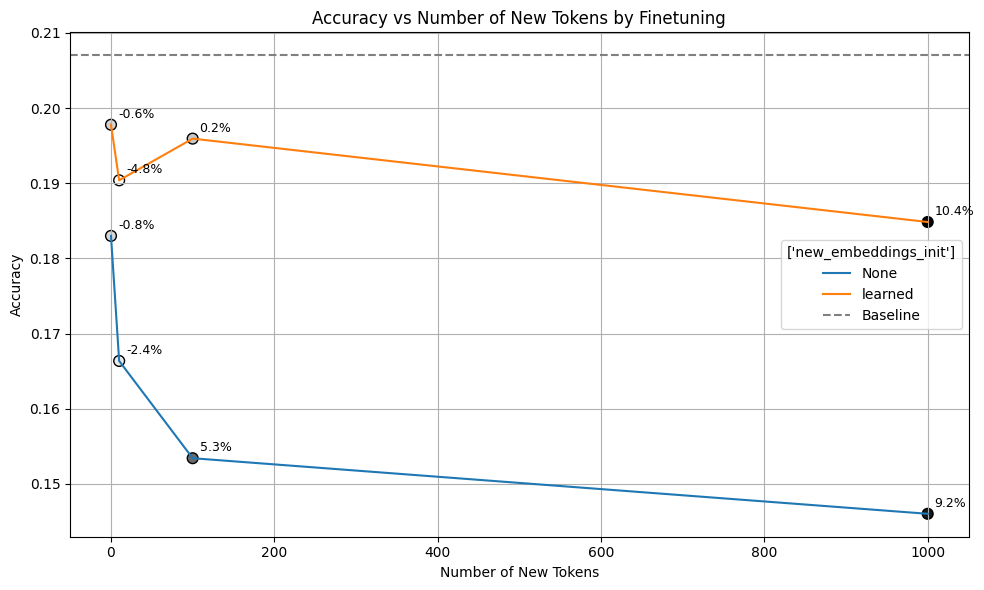

In [47]:
# Example: Scatter plot of Accuracy vs num_new_tokens
subset = df_flat[df_flat["model_name"] == "Llama-3.2-3B"]  # filter one model for clarity
base_line = subset[subset["num_new_tokens"] == "Baseline"]
subset = subset[subset["num_new_tokens"] != "Baseline"]

group_col = ["new_embeddings_init"]
metric = "prompt_level_strict_acc"

my_compression_plotter(subset, group_col, metric, base_line)

In [ ]:
# Example: Scatter plot of Accuracy vs num_new_tokens
subset = df_flat[df_flat["model_name"] == "Llama-3.2-3B-Instruct"]  # filter one model for clarity
print(subset)
base_line = subset[subset["num_new_tokens"] == "Baseline"]
subset = subset[subset["num_new_tokens"] != "Baseline"]

group_col = ["finetuning"]
metric = "prompt_level_strict_acc"

my_compression_plotter(subset, group_col, metric, base_line)

NameError: name 'df_flat' is not defined

# Compare Instruct models

In [56]:
templating_results = get_results(results_file_name, "templating")
# display(templating_results)
patching_results = get_results(results_file_name, "patching")
# display(patching_results)
patching_plus_finetuning = get_results(results_file_name, "baseline_embeddings")
patching_plus_finetuning = patching_plus_finetuning[patching_plus_finetuning["model_name"].str.contains("plus")]
# display(patching_plus_finetuning)



main_results = pd.concat([templating_results, patching_results, patching_plus_finetuning])
main_results.sort_values(by="prompt_level_strict_acc", ascending=True)
main_results.fillna("NAN", inplace=True)
main_results

Error: model_name_sanitized                              meta-llama__Llama-3.2-3B-Instruct
model_name                                                               meta-llama
task_name                                                                  baseline
exact_match                                                                     NAN
exact_match_stderr                                                              NAN
prompt_level_strict_acc                                                    0.700555
prompt_level_strict_acc_stderr                                              0.01971
inst_level_strict_acc                                                      0.780576
inst_level_strict_acc_stderr                                                    NAN
prompt_level_loose_acc                                                     0.752311
prompt_level_loose_acc_stderr                                              0.018576
inst_level_loose_acc                                                 

/cmlscratch/astein0/tmp/ipykernel_2514341/2063324347.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NAN' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  main_results.fillna("NAN", inplace=True)
/cmlscratch/astein0/tmp/ipykernel_2514341/2063324347.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  main_results["task_name"].replace("ifeval", "baseline", inplace=True)
/cmlscratch/astein0/tmp/ipykern

,model_name_sanitized,model_name,task_name,exact_match,exact_match_stderr,prompt_level_strict_acc,prompt_level_strict_acc_stderr,inst_level_strict_acc,inst_level_strict_acc_stderr,prompt_level_loose_acc,prompt_level_loose_acc_stderr,inst_level_loose_acc,inst_level_loose_acc_stderr,compression_ratio,learning_ratio,theoretical_compression_ratio,alias,limit,json_path,finetuning_params,total_batch_size,learning_rate,main_loss_type,embedding_init_strategy,num_new_tokens,unfreeze_params_steps,finetune_params_after_unfreeze,dataset,tokenizer_path,seed,reset_optimizer,warmup_steps,lr_schedule,target_modules,r,lora_alpha,lora_dropout,finetune_params_prefreeze,warmup_steps_prefreeze,lr_schedule_prefreeze
0,output__templating__043305d0-Llama-3.2-3B-Inst...,Llama-3.2-3B-Instruct,SFT,NAN,NAN,0.670980,0.020219,0.760192,NAN,0.730129,0.019102,0.809353,NAN,-0.010802,0.012554,0.000000,ifeval,NAN,eval_results/templating/output__templating__04...,embeddings,32.0,0.00002,all,NAN,0.0,500.0,lora,"magpie-default-tokenized_0,magpie-translation-...",meta-llama/Llama-3.2-3B-Instruct,1234.0,True,100.0,cosine,linear,8.0,16.0,0.05,NAN,NAN,NAN
1,output__templating__b0948c7c-Llama-3.2-3B-Inst...,Llama-3.2-3B-Instruct,mixed,NAN,NAN,0.597043,0.021107,0.696643,NAN,0.683919,0.020008,0.774580,NAN,0.035448,0.024583,0.060531,ifeval,NAN,eval_results/templating/output__templating__b0...,embeddings,32.0,0.00002,mixed,merge,100.0,500.0,lora,"magpie-default-tokenized_100,magpie-translatio...",/cmlscratch/astein0/efficient_tokenization_for...,1234.0,True,100.0,cosine,linear,8.0,16.0,0.05,NAN,NAN,NAN
2,output__templating__f2270e48-Llama-3.2-3B-Inst...,Llama-3.2-3B-Instruct,mixed,NAN,NAN,0.628466,0.020794,0.723022,NAN,0.689464,0.019912,0.779376,NAN,-0.000015,0.014769,0.014429,ifeval,NAN,eval_results/templating/output__templating__f2...,embeddings,32.0,0.00002,mixed,merge,10.0,500.0,first_last,"magpie-default-tokenized_10,magpie-translation...",/cmlscratch/astein0/efficient_tokenization_for...,1234.0,True,100.0,cosine,NAN,NAN,NAN,NAN,NAN,NAN,NAN
3,output__templating__eb5e0411-Llama-3.2-3B-Inst...,Llama-3.2-3B-Instruct,mixed,NAN,NAN,0.645102,0.020591,0.733813,NAN,0.720887,0.019303,0.802158,NAN,0.005254,0.024059,0.017551,ifeval,NAN,eval_results/templating/output__templating__eb...,embeddings,32.0,0.00002,mixed,merge,10.0,500.0,lora,"magpie-default-tokenized_10,magpie-translation...",/cmlscratch/astein0/efficient_tokenization_for...,1234.0,True,100.0,cosine,linear,8.0,16.0,0.05,NAN,NAN,NAN
4,output__templating__ce7afe78-Llama-3.2-3B-Inst...,Llama-3.2-3B-Instruct,mixed,NAN,NAN,0.613678,0.020953,0.717026,NAN,0.687616,0.019944,0.780576,NAN,0.020545,0.034478,0.055265,ifeval,NAN,eval_results/templating/output__templating__ce...,embeddings,32.0,0.00002,mixed,merge,100.0,500.0,first_last,"magpie-default-tokenized_100,magpie-translatio...",/cmlscratch/astein0/efficient_tokenization_for...,1234.0,True,100.0,cosine,NAN,NAN,NAN,NAN,NAN,NAN,NAN
5,output__templating__747113b2-Llama-3.2-3B-Inst...,Llama-3.2-3B-Instruct,mixed,NAN,NAN,0.543438,0.021435,0.655875,NAN,0.617375,0.020915,0.726619,NAN,0.051198,0.076424,0.131187,ifeval,NAN,eval_results/templating/output__templating__74...,embeddings,32.0,0.00002,mixed,merge,1000.0,500.0,lora,"magpie-default-tokenized_1000,magpie-translati...",/cmlscratch/astein0/efficient_tokenization_for...,1234.0,True,100.0,cosine,linear,8.0,16.0,0.05,NAN,NAN,NAN
6,output__templating__381d099f-Llama-3.2-3B-Inst...,Llama-3.2-3B-Instruct,mixed,NAN,NAN,0.608133,0.021007,0.718225,NAN,0.670980,0.020219,0.768585,NAN,0.023592,0.095626,0.120402,ifeval,NAN,eval_results/templating/output__templating__38...,embeddings,32.0,0.00002,mixed,merge,1000.0,500.0,first_last,"magpie-default-tokenized_1000,magpie-translati...",/cmlscratch/astein0/efficient_tokenization_for...,1234.0,True,100.0,cosine,NAN,NAN,NAN,NAN,NAN,NAN,NAN
7,meta-llama__Llama-3.2-3B-Instruct,meta-llama,baseline,NAN,NAN,0.700555,0.019710,0.780576,NAN,0.752311,0.018576,0.820144,NAN,-0.010601,0.012159,0.000000,ifeva

In [60]:
# this works for the baseline_embeddings and patched experiments
agg_col = ["num_new_tokens", "finetuning_params", "model_name", "model_name_sanitized", "finetune_params_after_unfreeze"]
agged = get_aggregated_results(main_results, agg_col)
agged.reset_index(inplace=True)

records = []
agged.columns = ['_'.join(col).rstrip('_') if isinstance(col, tuple) else col for col in agged.columns]
for _, row in agged.iterrows():
    data_dict = {}
    if not row["model_name_sanitized"].startswith("output"):
        model_name = row["model_name_sanitized"].split("__")[-1]
        # new_embeddings_init = "None"
        finetuning = "None"
        row["num_new_tokens"] = "Baseline"
    elif row["model_name"] == "patching":
        model_name = "Llama-3.2-3B-Instruct"
        # new_embeddings_init = "patched"
        finetuning = "patched"
    elif row["model_name"] == "Llama-3.2-3B" and row["finetuning_params"] == "embeddings":
        model_name = "Llama-3.2-3B"
        # new_embeddings_init = "None"
        finetuning = "embeddings"
    elif "plus" in row["model_name"]:
        model_name = "Llama-3.2-3B-Instruct"
        finetuning = f"patched + {row['finetuning_params']}"
    elif row["model_name"].startswith("Llama-3.2-3B-Instruct") and row["num_new_tokens"] != "NAN":
        model_name = "Llama-3.2-3B-Instruct"
        # new_embeddings_init = "None"
        finetuning = f"{row['finetuning_params']} + {row['finetune_params_after_unfreeze']}"
    else:  # loraed
        model_name = "Llama-3.2-3B"
        new_embeddings_init = "learned"
        finetuning = "lora"

    data_dict["model_name"] = model_name
    # data_dict["new_embeddings_init"] = new_embeddings_init
    data_dict["finetuning"] = finetuning
    try:
        data_dict["num_new_tokens"] = int(row["num_new_tokens"])
    except:
        data_dict["num_new_tokens"] = row["num_new_tokens"]
    data_dict["prompt_level_strict_acc"] = row["prompt_level_strict_acc_mean"]
    data_dict["compression_ratio"] = row["compression_ratio_mean"]
    data_dict["theoretical_compression_ratio"] = row["theoretical_compression_ratio_mean"]
    data_dict["learning_ratio"] = row["learning_ratio_mean"]
    records.append(data_dict)

df = pd.DataFrame(records)
display(df)



,model_name,finetuning,num_new_tokens,prompt_level_strict_acc,compression_ratio,theoretical_compression_ratio,learning_ratio
0,Llama-3.2-3B-Instruct,embeddings + lora,0,0.670980,-0.010802,0.000000,0.012554
1,Llama-3.2-3B-Instruct,embeddings + first_last,0,0.659889,-0.011285,0.000000,0.013064
2,Llama-3.2-3B-Instruct,patched,10,0.680222,-0.006470,0.017298,0.025475
3,Llama-3.2-3B-Instruct,embeddings + lora,10,0.645102,0.005254,0.017551,0.024059
4,Llama-3.2-3B-Instruct,embeddings + first_last,10,0.628466,-0.000015,0.014429,0.014769
5,Llama-3.2-3B-Instruct,patched + lora,10,0.534196,0.001799,0.014978,0.037306
6,Llama-3.2-3B-Instruct,patched,100,0.659889,0.006034,0.063345,0.058326
7,Llama-3.2-3B-Instruct,embeddings + lora,100,0.597043,0.035448,0.060531,0.024583
8,Llama-3.2-3B-Instruct,embeddings + first_last,100,0.613678,0.020545,0.055265,0.034478
9,Llama-3.2-3B-Instruct,patched + lora,100,0.467652,0.037431,0.051094,0.025288


               model_name               finetuning num_new_tokens  \
0   Llama-3.2-3B-Instruct        embeddings + lora              0   
1   Llama-3.2-3B-Instruct  embeddings + first_last              0   
2   Llama-3.2-3B-Instruct                  patched             10   
3   Llama-3.2-3B-Instruct        embeddings + lora             10   
4   Llama-3.2-3B-Instruct  embeddings + first_last             10   
5   Llama-3.2-3B-Instruct           patched + lora             10   
6   Llama-3.2-3B-Instruct                  patched            100   
7   Llama-3.2-3B-Instruct        embeddings + lora            100   
8   Llama-3.2-3B-Instruct  embeddings + first_last            100   
9   Llama-3.2-3B-Instruct           patched + lora            100   
10  Llama-3.2-3B-Instruct                  patched           1000   
11  Llama-3.2-3B-Instruct  embeddings + first_last           1000   
12  Llama-3.2-3B-Instruct        embeddings + lora           1000   
13  Llama-3.2-3B-Instruct         

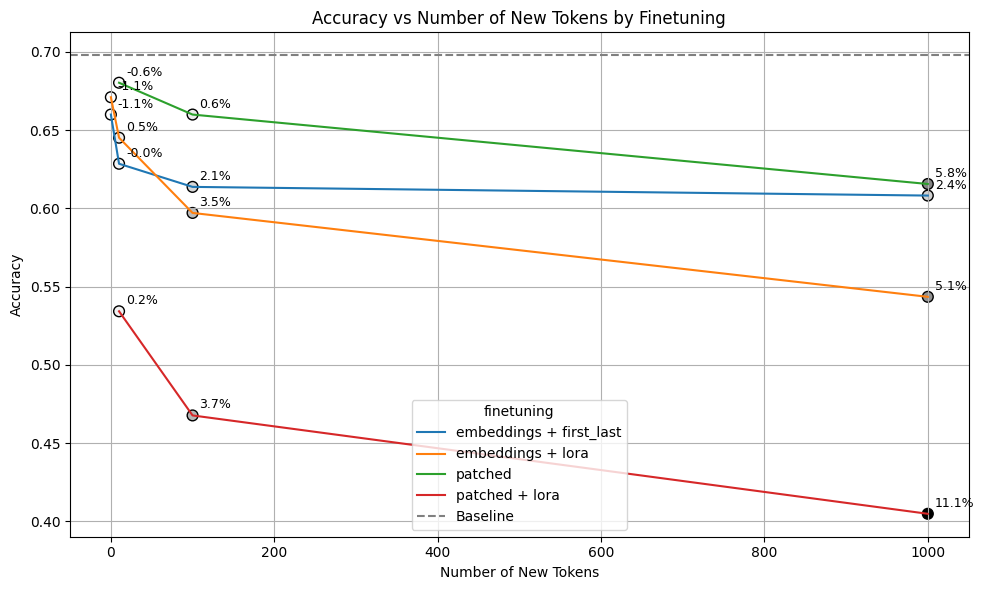

In [61]:
# Example: Scatter plot of Accuracy vs num_new_tokens
subset = df[df["model_name"] == "Llama-3.2-3B-Instruct"]  # filter one model for clarity
print(subset)
base_line = subset[subset["num_new_tokens"] == "Baseline"]
subset = subset[subset["num_new_tokens"] != "Baseline"]

group_col = ["finetuning"]
metric = "prompt_level_strict_acc"

my_compression_plotter(subset, group_col, metric, base_line)

# FULL PATCHING

In [4]:
experiment = "full_patching"
results_file_name = "eval_results.csv"
main_results = get_results(results_file_name, experiment)
# main_results.sort_values(by="exact_match", ascending=True)
# print(main_results.sort_values(by="prompt_level_strict_acc", ascending=True))

if experiment == "longer_embeddings":
    main_results.loc[main_results["finetuning_params"] == "embeddings", "finetuning_params"] = "lora"

# templating_results = get_results(results_file_name, "templating")
# patching_results = get_results(results_file_name, "patching")
# main_results = pd.concat([templating_results, patching_results])
main_results.sort_values(by="prompt_level_strict_acc", ascending=True)
main_results.fillna("NAN", inplace=True)
# display(main_results)

agg_col = ["num_new_tokens", "finetuning_params", "model_name", "trained_model_name", "model_name_sanitized", "dataset_str", "embeddings_init"]
agged = get_aggregated_results(main_results, agg_col)
agged.reset_index(inplace=True)
display(agged)

records = []
agged.columns = ['_'.join(col).rstrip('_') if isinstance(col, tuple) else col for col in agged.columns]
for _, row in agged.iterrows():
    data_dict = {}
    model_name = row["model_name"]
    finetuning = row["finetuning_params"]
    new_embeddings_init = row.get("embeddings_init", "None")
    dataset = row["dataset_str"]
    trained_model_name = row["trained_model_name"]
    if row["trained_model_name"].startswith("meta-llama"):
        num_new_tokens = "Baseline"
        finetuning = "None"
        model_name = row["model_name"]
    else:
        num_new_tokens = row["num_new_tokens"]

    # if new_embeddings_init != "None":
    #     model_name = f"{model_name}-Instruct" # TODO CLEAN

    if row["model_name"] == "Llama-3.2-3B" and "Instruct" in row["model_name_sanitized"]:
        # legacy
        if new_embeddings_init == "new_only":
            new_embeddings_init = "patched_new_tokens"
        else:
            new_embeddings_init = "patched_all_embeddings"
        model_name = f"{model_name}-Instruct"  # TODO CLEAN
  
    data_dict["model_name"] = model_name
    data_dict["new_embeddings_init"] = new_embeddings_init
    data_dict["finetuning"] = finetuning
    data_dict["dataset"] = dataset
    data_dict["trained_model_name"] = trained_model_name
    try:
        data_dict["num_new_tokens"] = int(num_new_tokens)
    except:
        data_dict["num_new_tokens"] = num_new_tokens
    
    score_list = [row["prompt_level_strict_acc_mean"], row["inst_level_strict_acc_mean"], row["prompt_level_loose_acc_mean"], row["inst_level_loose_acc_mean"]]
    # data_dict["prompt_level_strict_acc"] = row["prompt_level_strict_acc_mean"]
    data_dict["scores"] = sum(score_list) / len(score_list)
    data_dict["compression_ratio"] = row["compression_ratio_mean"]
    data_dict["theoretical_compression_ratio"] = row["theoretical_compression_ratio_mean"]
    data_dict["learning_ratio"] = row["learning_ratio_mean"]
    records.append(data_dict)

df = pd.DataFrame(records)
display(df)



/cmlscratch/astein0/tmp/ipykernel_3167261/405337152.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NAN' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  main_results.fillna("NAN", inplace=True)
/cmlscratch/astein0/tmp/ipykernel_3167261/405337152.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  main_results["task_name"].replace("ifeval", "baseline", inplace=True)


Error: model_name_sanitized                                       meta-llama__Llama-3.2-3B
trained_model_name                                         meta-llama__Llama-3.2-3B
model_name                                                             Llama-3.2-3B
embeddings_init                                                                 NAN
task_name                                                                  baseline
exact_match                                                                     NAN
exact_match_stderr                                                              NAN
prompt_level_strict_acc                                                    0.195933
prompt_level_strict_acc_stderr                                             0.017081
inst_level_strict_acc                                                       0.32494
inst_level_strict_acc_stderr                                                    NAN
prompt_level_loose_acc                                               

num_new_tokens finetuning_params             model_name  \
                                                             
0             0.0        embeddings           Llama-3.2-3B   
1             0.0        embeddings           Llama-3.2-3B   
2             0.0        embeddings           Llama-3.2-3B   
3             0.0        embeddings           Llama-3.2-3B   
4             0.0        embeddings           Llama-3.2-3B   
5             0.0        embeddings  Llama-3.2-3B-Instruct   
6             0.0        embeddings  Llama-3.2-3B-Instruct   
7             0.0   new_tokens_only           Llama-3.2-3B   
8             0.0   new_tokens_only           Llama-3.2-3B   
9             0.0   new_tokens_only           Llama-3.2-3B   
10            0.0   new_tokens_only           Llama-3.2-3B   
11            0.0   new_tokens_only  Llama-3.2-3B-Instruct   
12            0.0   new_tokens_only  Llama-3.2-3B-Instruct   
13           10.0        embeddings           Llama-3.2-3B   
14           10.0        embeddings           Llama-3.2-3B   
15           10.0        embeddings           Llama-3.2-3B   
16           10.0        embeddings           Llama-3.2-3B   
17           10.0        embeddings           Llama-3.2-3B   
18           10.0        embeddings  Llama-3.2-3B-Instruct   
19           10.0        embeddings  Llama-3.2-3B-Instruct   
20           10.0   new_tokens_only           Llama-3.2-3B   
21           10.0   new_tokens_only           Llama-3.2-3B   
22           10.0   new_tokens_only           Llama-3.2-3B   
23           10.0   new_tokens_only           Llama-3.2-3B   
24           10.0   new_tokens_only  Llama-3.2-3B-Instruct   
25           10.0   new_tokens_only  Llama-3.2-3B-Instruct   
26          100.0        embeddings           Llama-3.2-3B   
27          100.0        embeddings           Llama-3.2-3B   
28          100.0        embeddings           Llama-3.2-3B   
29          100.0        embeddings           Llama-3.2-3B   
30          100.0        embeddings           Llama-3.2-3B   
31          100.0        embeddings  Llama-3.2-3B-Instruct   
32          100.0        embeddings  Llama-3.2-3B-Instruct   
33          100.0   new_tokens_only           Llama-3.2-3B   
34          100.0   new_tokens_only           Llama-3.2-3B   
35          100.0   new_tokens_only           Llama-3.2-3B   
36          100.0   new_tokens_only           Llama-3.2-3B   
37          100.0   new_tokens_only  Llama-3.2-3B-Instruct   
38          100.0   new_tokens_only  Llama-3.2-3B-Instruct   
39          500.0        embeddings           Llama-3.2-3B   
40          500.0        embeddings           Llama-3.2-3B   
41          500.0        embeddings           Llama-3.2-3B   
42          500.0        embeddings           Llama-3.2-3B   
43          500.0        embeddings           Llama-3.2-3B   
44          500.0        embeddings  Llama-3.2-3B-Instruct   
45          500.0        embeddings  Llama-3.2-3B-Instruct   
46          500.0   new_tokens_only           Llama-3.2-3B   
47          500.0   new_tokens_only           Llama-3.2-3B   
48          500.0   new_tokens_only           Llama-3.2-3B   
49          500.0   new_tokens_only           Llama-3.2-3B   
50          500.0   new_tokens_only  Llama-3.2-3B-Instruct   
51          500.0   new_tokens_only  Llama-3.2-3B-Instruct   
52         1000.0        embeddings           Llama-3.2-3B   
53         1000.0        embeddings           Llama-3.2-3B   
54         1000.0        embeddings           Llama-3.2-3B   
55         1000.0        embeddings           Llama-3.2-3B   
56         1000.0        embeddings           Llama-3.2-3B   
57         1000.0        embeddings  Llama-3.2-3B-Instruct   
58         1000.0        embeddings  Llama-3.2-3B-Instruct   
59         1000.0   new_tokens_only           Llama-3.2-3B   
60         1000.0   new_tokens_only           Llama-3.2-3B   
61         1000.0   new_tokens_only           Llama-3.2-3B   
62         1000.0   new_tokens_only

,model_name,new_embeddings_init,finetuning,dataset,trained_model_name,num_new_tokens,scores,compression_ratio,theoretical_compression_ratio,learning_ratio
0,Llama-3.2-3B,NAN,embeddings,default,74ed1b01-Llama-3.2-3B-mixed-0,0,0.227127,-0.000226,0.000000,0.000229
1,Llama-3.2-3B-Instruct,patched_all_embeddings,embeddings,default,74ed1b01-Llama-3.2-3B-mixed-0,0,0.533124,0.012280,0.000000,-0.002480
2,Llama-3.2-3B-Instruct,patched_new_tokens,embeddings,default,74ed1b01-Llama-3.2-3B-mixed-0,0,0.762922,-0.010773,0.000000,0.012387
3,Llama-3.2-3B-Instruct,patched_new_tokens,embeddings,"translation, default",d1f6703c-Llama-3.2-3B-mixed-0,0,0.761086,-0.010761,0.000000,0.012375
4,Llama-3.2-3B,NAN,embeddings,"translation, default",output__full_patching__d1f6703c-Llama-3.2-3B-m...,0,0.215986,-0.001223,0.000000,0.001373
5,Llama-3.2-3B-Instruct,NAN,embeddings,default,368f5252-Llama-3.2-3B-Instruct-mixed-0,0,0.641485,-0.011691,0.000000,0.017971
6,Llama-3.2-3B-Instruct,NAN,embeddings,"translation, default",output__full_patching__8d72bbbe-Llama-3.2-3B-I...,0,0.635252,-0.010000,0.000000,0.011621
7,Llama-3.2-3B-Instruct,patched_new_tokens,new_tokens_only,default,8760b763-Llama-3.2-3B-mixed-0,0,0.762922,-0.010773,0.000000,0.012387
8,Llama-3.2-3B-Instruct,patched_new_tokens,new_tokens_only,"translation, default",a84197a7-Llama-3.2-3B-mixed-0,0,0.762922,-0.010773,0.000000,0.012387
9,Llama-3.2-3B,NAN,new_tokens_only,default,output__full_patching__8760b763-Llama-3.2-3B-m...,0,0.276873,-0.000266,0.000000,0.006193


11


,model_name,new_embeddings_init,finetuning,dataset,trained_model_name,num_new_tokens,scores,compression_ratio,theoretical_compression_ratio,learning_ratio
4,Llama-3.2-3B,NAN,embeddings,"translation, default",output__full_patching__d1f6703c-Llama-3.2-3B-m...,0,0.215986,-0.001223,0.000000,0.001373
10,Llama-3.2-3B,NAN,new_tokens_only,"translation, default",output__full_patching__a84197a7-Llama-3.2-3B-m...,0,0.272277,0.001207,0.000000,0.004820
17,Llama-3.2-3B,NAN,embeddings,"translation, default",output__full_patching__bd539cf5-Llama-3.2-3B-m...,10,0.245649,0.014895,0.017731,0.002959
22,Llama-3.2-3B,NAN,new_tokens_only,"translation, default",output__full_patching__d2d49ae1-Llama-3.2-3B-m...,10,0.262073,0.006792,0.016143,0.018304
30,Llama-3.2-3B,NAN,embeddings,"translation, default",output__full_patching__2ecfe6ea-Llama-3.2-3B-m...,100,0.210191,0.040349,0.046784,0.006330
35,Llama-3.2-3B,NAN,new_tokens_only,"translation, default",output__full_patching__3c315a04-Llama-3.2-3B-m...,100,0.266969,0.039745,0.064240,0.028531
43,Llama-3.2-3B,NAN,embeddings,"translation, default",output__full_patching__e8e7ce8d-Llama-3.2-3B-m...,500,0.231548,0.089000,0.100258,0.010453
49,Llama-3.2-3B,NAN,new_tokens_only,"translation, default",output__full_patching__234bdfaa-Llama-3.2-3B-m...,500,0.264458,0.147659,0.192847,0.043606
56,Llama-3.2-3B,NAN,embeddings,"translation, default",output__full_patching__461b9dfe-Llama-3.2-3B-m...,1000,0.241352,0.121145,0.147647,0.048861
62,Llama-3.2-3B,NAN,new_tokens_only,"translation, default",output__full_patching__ba7c8b60-Llama-3.2-3B-m...,1000,0.258688,0.133380,0.170377,0.034137


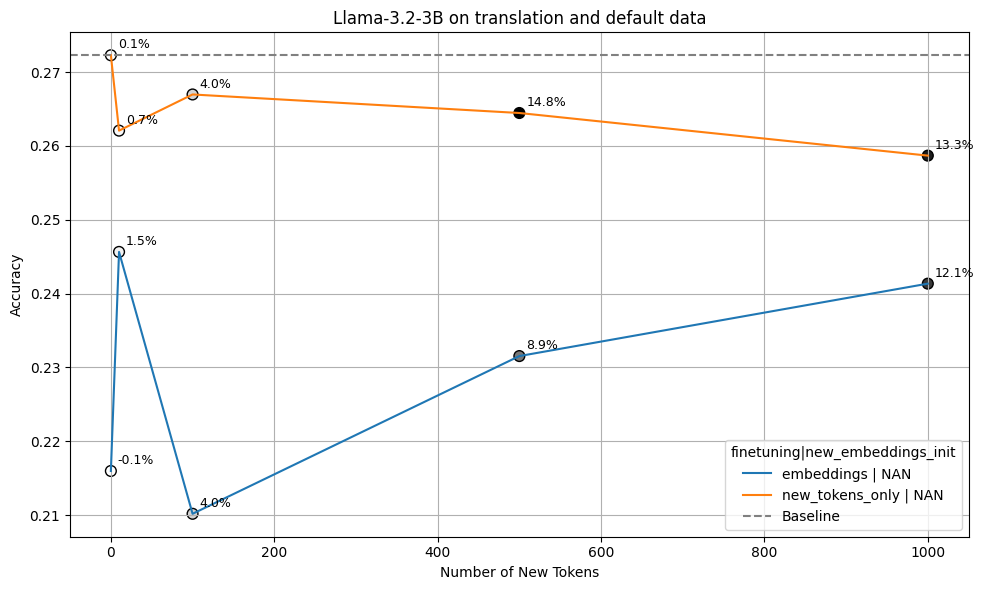

In [7]:
subset = df.copy()
model = "Llama-3.2-3B"
# model = "Llama-3.2-3B-Instruct"
dataset = "translation, default"
# dataset = "default"
subset = subset[subset["model_name"] == model]  # filter one model for clarity
subset = subset[subset["dataset"].isin([dataset, "unknown"])]
# subset = subset[subset["dataset"].isin(["default", "unknown"])]

print(len(subset))
display(subset)
base_line = subset[subset["num_new_tokens"] == "Baseline"]
subset = subset[subset["num_new_tokens"] != "Baseline"]

group_col = ["finetuning", "new_embeddings_init"]
# metric = "prompt_level_strict_acc"
metric = "scores"

my_compression_plotter(subset, group_col, metric, base_line, title = f"{model} on {dataset.replace(', ', ' and ')} data")